In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
from diffusers import DDPMScheduler, UNet2DModel, DDIMScheduler
import matplotlib.pyplot as plt
import numpy as np

C:\Users\fomka\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
BATCH_SIZE = 8
IMAGE_SIZE = 64
NUM_EPOCHS = 50
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Фильтруем None значения
dataset = dataset.filter(lambda x: x['image'] is not None)

# Трансформации
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def transform_examples(examples):
    images = []
    for image in examples["image"]:
        try:
            if image.mode != 'RGB':
                image = image.convert('RGB')
            images.append(transform(image))
        except:
            images.append(torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE))
    return {"image": images}

dataset.set_transform(transform_examples)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print(f"Dataset loaded: {len(dataset)} images")

Repo card metadata block was not found. Setting CardData to empty.


Dataset loaded: 1000 images


In [6]:
model = UNet2DModel(
    sample_size=IMAGE_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(32, 64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
)

scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_schedule='squaredcos_cap_v2',
)

model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [7]:
model.train()

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for batch in dataloader:
        images = batch["image"].to(DEVICE)

        # Генерируем шум и временные шаги
        noise = torch.randn_like(images)
        timesteps = torch.randint(0, 1000, (images.shape[0],), device=DEVICE).long()

        # Добавляем шум
        noisy_images = scheduler.add_noise(images, noise, timesteps)

        # Предсказываем шум
        noise_pred = model(noisy_images, timesteps).sample
        loss = nn.functional.mse_loss(noise_pred, noise)

        # Оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}")



Epoch 1/50, Loss: 0.4077
Epoch 2/50, Loss: 0.1727
Epoch 3/50, Loss: 0.1392
Epoch 4/50, Loss: 0.1249
Epoch 5/50, Loss: 0.0978
Epoch 6/50, Loss: 0.0944
Epoch 7/50, Loss: 0.0823
Epoch 8/50, Loss: 0.0814
Epoch 9/50, Loss: 0.0789
Epoch 10/50, Loss: 0.0752
Epoch 11/50, Loss: 0.0693
Epoch 12/50, Loss: 0.0659
Epoch 13/50, Loss: 0.0643
Epoch 14/50, Loss: 0.0579
Epoch 15/50, Loss: 0.0659
Epoch 16/50, Loss: 0.0617
Epoch 17/50, Loss: 0.0576
Epoch 18/50, Loss: 0.0572
Epoch 19/50, Loss: 0.0567
Epoch 20/50, Loss: 0.0562
Epoch 21/50, Loss: 0.0578
Epoch 22/50, Loss: 0.0571
Epoch 23/50, Loss: 0.0552
Epoch 24/50, Loss: 0.0527
Epoch 25/50, Loss: 0.0510
Epoch 26/50, Loss: 0.0514
Epoch 27/50, Loss: 0.0523
Epoch 28/50, Loss: 0.0460
Epoch 29/50, Loss: 0.0492
Epoch 30/50, Loss: 0.0498
Epoch 31/50, Loss: 0.0491
Epoch 32/50, Loss: 0.0515
Epoch 33/50, Loss: 0.0449
Epoch 34/50, Loss: 0.0487
Epoch 35/50, Loss: 0.0489
Epoch 36/50, Loss: 0.0498
Epoch 37/50, Loss: 0.0480
Epoch 38/50, Loss: 0.0402
Epoch 39/50, Loss: 0.

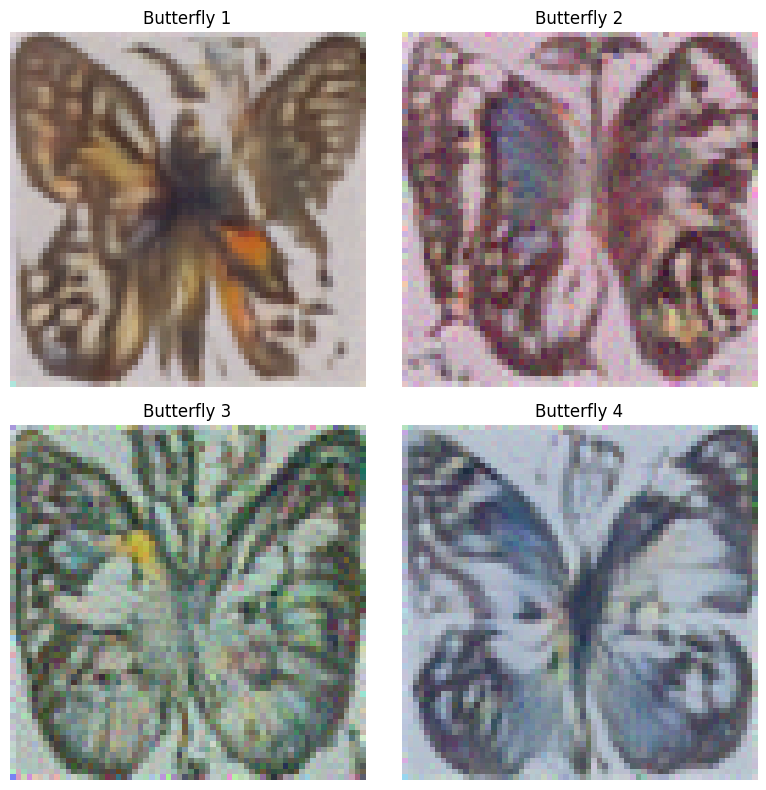

In [23]:
model.eval()

with torch.no_grad():
    # Стартуем с шума
    sample = torch.randn(4, 3, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    scheduler.set_timesteps(10)

    # Постепенно удаляем шум
    for t in scheduler.timesteps:
        residual = model(sample, t).sample
        sample = scheduler.step(residual, t, sample).prev_sample

    # Денормализуем
    sample = torch.clamp(sample, -1, 1)
    sample = (sample + 1) / 2
    generated_images = sample.cpu().permute(0, 2, 3, 1).numpy()

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i])
    ax.axis('off')
    ax.set_title(f"Butterfly {i+1}")

plt.tight_layout()
plt.show()


In [24]:
 checkpoint_path = f"checkpoints/butterfly_model_weights.pt"

 torch.save({
     'epoch': 50,
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     'loss': 0.0421,
     'config': model.config,
     'scheduler_config': scheduler.config
 }, checkpoint_path)